In [13]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from utils import *
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
data = pd.DataFrame(np.load("full_SCOP_nodup_seqs_nonan.npy",  allow_pickle=True))
data.columns = ["DSSP", "SCOPid", "avg_hidden", "name", "Sequence"]
data["Class"] = data.SCOPid.map(lambda s: str(s).split('.')[0])
data = data[~data['Class'].isin(["d","e"])]
avg_hidden_mLSTM = data['avg_hidden']
data = data.drop('avg_hidden', axis=1)
columns = ['SCOPid', 'DSSP', 'name']
SCOP_labels = data['Class']

In [15]:
file = "scop_sequences.txt"
write_sequences_to_txt(data, file)
file_formatted = "formatted_sequences.txt"
format_sequences(file, file_formatted)

In [16]:
pad_sequences(file_formatted, file, "temp.txt")
vocab_size = 26
embedding_size = 10
hidden_size = 64
batches = create_batches(file, 64)


Lettura sequenze: 21342 sequenze [00:02, 7799.66 sequenze/s]


Sequenze elaborate e suddivise in addestramento e test.


Creazione batch: 100%|██████████| 334/334 [00:04<00:00, 79.14 batch/s]


In [17]:
path = "biLSTM_weights.pth"
model = biLSTM(vocab_size, embedding_size, hidden_size).to(device)
model.load_state_dict(torch.load(path))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
n_epochs = 25
for epoch in range(n_epochs):
    total_loss = 0
    with tqdm(batches, desc=f"Epoch {epoch+1}") as tqdm_iterator:
        for sequences in tqdm_iterator:
            sequences = sequences.to(device)
            optimizer.zero_grad()
            output, _ = model(sequences)
            output = output.permute(0, 2, 1)
            loss = criterion(output[:, :, :-1], sequences[:, 1:])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            tqdm_iterator.set_postfix({"loss": loss.item()})

    #average_loss = total_loss / len(batches)
    #print(f'Epoch {epoch}, Average Loss: {average_loss}')


Epoch 25: 100%|██████████| 334/334 [00:10<00:00, 30.88it/s, loss=1.25e-9] 


In [19]:
avg_hidden = []
total_loss = 0

with tqdm(batches) as tqdm_iterator:
        for sequences in tqdm_iterator:
            sequences = sequences.to(device)
            output, avg_hidden = model(sequences, avg_hidden)
            output = output.permute(0, 2, 1)
            loss = criterion(output[:, :, :-1], sequences[:, 1:])
            total_loss += loss.item()
            tqdm_iterator.set_postfix({"loss": loss.item()})

        average_loss = total_loss / len(batches)  # Calcoliamo la loss media dividendo per il numero totale di sequenze
        print(f'Average Loss: {average_loss}')

100%|██████████| 334/334 [00:04<00:00, 70.32it/s, loss=1.29e-9] 

Average Loss: 2.9995133469499815e-09


In [20]:
embedding_batches = np.array(avg_hidden[:-1])
last_batch = np.array(avg_hidden[-1])
avg_hidden_states = np.vstack(embedding_batches)
avg_hidden_states = np.vstack([avg_hidden_states, last_batch])
print(avg_hidden_states.shape)

X = avg_hidden_states
y = SCOP_labels

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
classification_rep = classification_report(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

(21342, 128)
Accuracy: 0.889435464980089
Classification Report:
              precision    recall  f1-score   support

           a       0.88      0.81      0.84      1021
           b       0.91      0.91      0.91      1596
           c       0.85      0.93      0.89      1309
           f       1.00      0.65      0.79        66
           g       0.97      0.94      0.96       277

    accuracy                           0.89      4269
   macro avg       0.92      0.85      0.88      4269
weighted avg       0.89      0.89      0.89      4269



In [21]:
X = np.array(avg_hidden_mLSTM.tolist())
y = SCOP_labels

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
classification_rep = classification_report(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9725931131412509
Classification Report:
              precision    recall  f1-score   support

           a       0.96      0.97      0.96      1021
           b       0.98      0.98      0.98      1596
           c       0.98      0.96      0.97      1309
           f       1.00      0.89      0.94        66
           g       0.97      0.97      0.97       277

    accuracy                           0.97      4269
   macro avg       0.98      0.96      0.97      4269
weighted avg       0.97      0.97      0.97      4269



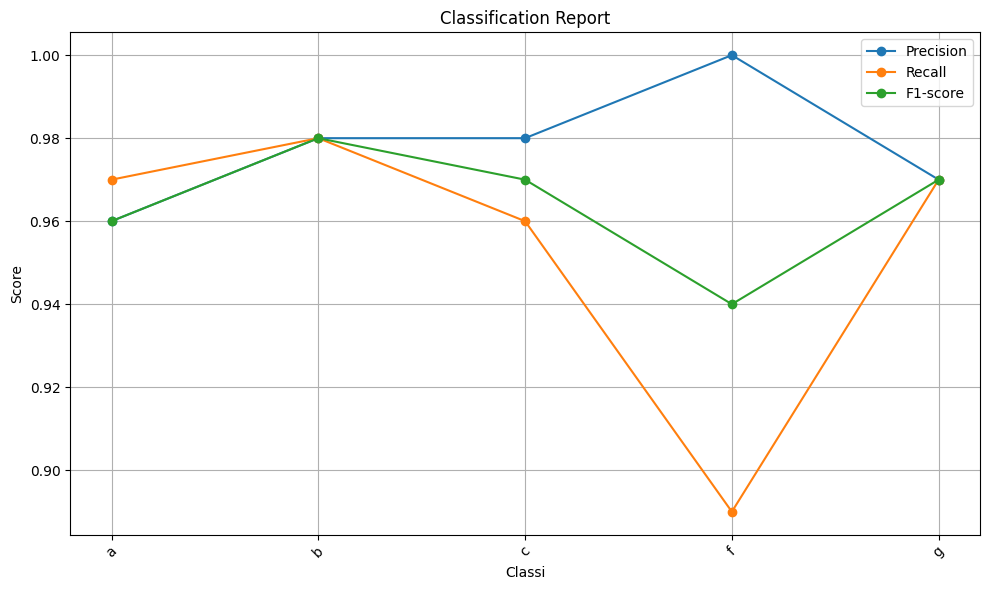

In [22]:
lines = classification_rep.split('\n')[2:-5]
classes = []
precision = []
recall = []
f1_score = []
support = []
for line in lines:
    data = line.split()
    classes.append(data[0])
    precision.append(float(data[1]))
    recall.append(float(data[2]))
    f1_score.append(float(data[3]))
    support.append(float(data[4]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(classes, precision, label='Precision', marker='o')
ax.plot(classes, recall, label='Recall', marker='o')
ax.plot(classes, f1_score, label='F1-score', marker='o')
ax.set_xlabel('Classi')
ax.set_ylabel('Score')
ax.set_title('Classification Report')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

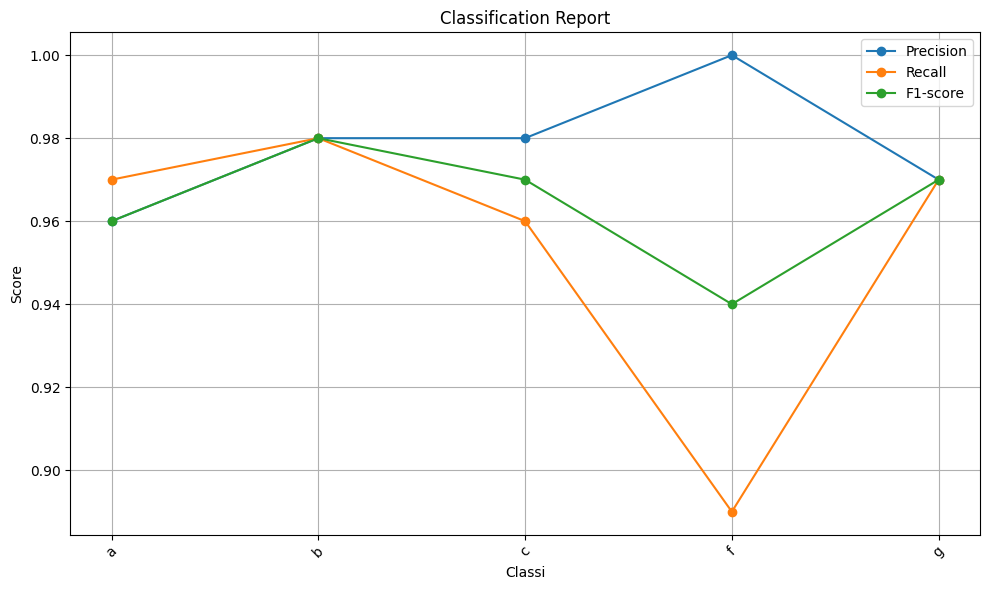

In [23]:
lines = classification_rep.split('\n')[2:-5]
classes = []
precision = []
recall = []
f1_score = []
support = []
for line in lines:
    data = line.split()
    classes.append(data[0])
    precision.append(float(data[1]))
    recall.append(float(data[2]))
    f1_score.append(float(data[3]))
    support.append(float(data[4]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(classes, precision, label='Precision', marker='o')
ax.plot(classes, recall, label='Recall', marker='o')
ax.plot(classes, f1_score, label='F1-score', marker='o')
ax.set_xlabel('Classi')
ax.set_ylabel('Score')
ax.set_title('Classification Report')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [24]:

tsne = TSNE(n_jobs=16, perplexity=600, random_state=42)
ts = tsne.fit_transform(avg_hidden_states)

In [25]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2, n_epochs=100, random_state=42)
umap_embedding = umap_model.fit_transform(avg_hidden_states)


c:\Users\paolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\paolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3425583169.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3425583169.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3425583169.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3425583169.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting 

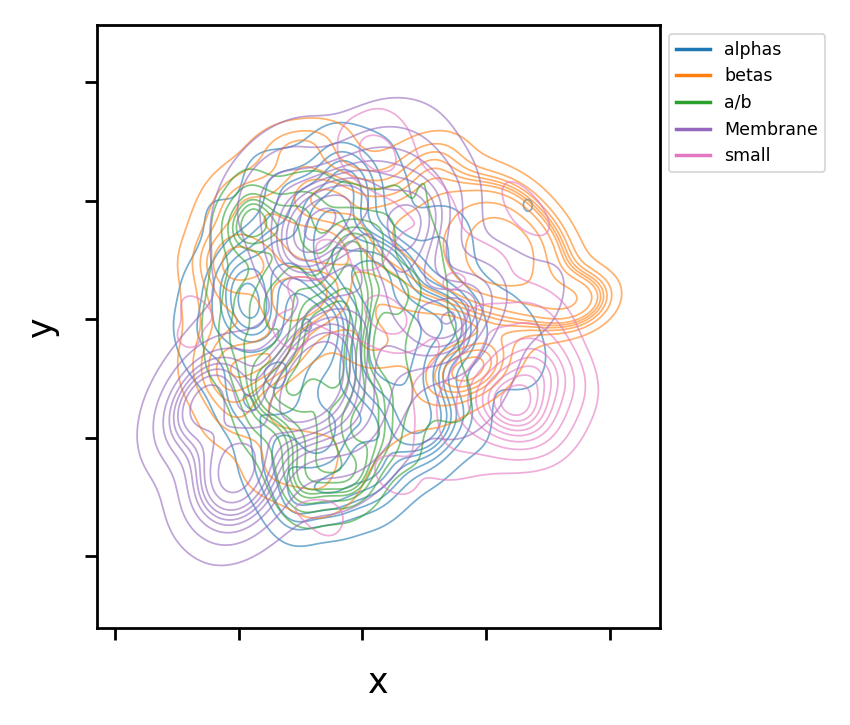

In [26]:
fig = plt.figure(figsize=(3.5, 3), dpi=250)
ax = fig.add_subplot(111)

label_order = [
    "a",
    "b",
    "c",
    "f",
    "g"
]

colors = {
    "a": sns.color_palette()[0],
    "b": sns.color_palette()[1],
    "c": sns.color_palette()[2],
    "d": sns.color_palette()[8],
    "e": sns.color_palette()[5],
    "f": sns.color_palette()[4],
    "g": sns.color_palette()[6],
}

pretty_names = {
    "a": "alphas",
    "b": "betas",
    "c": "a/b",
    "d": "a+b",
    "e": "Multi domain",
    "f": "Membrane",
    "g": "small",
}

colorpal = [colors[o] for o in label_order]
'''
for i,cl in enumerate(test_set['Class'].unique()):
    mask = test_set['Class'] == cl
    x = ts[mask,0]
    print(x.shape)
    y = ts[mask,1]
    print(y.shape)
    ax.scatter(x=x,y=y,s=1, c=colorpal[i])
'''
for i, cl in enumerate(label_order):
    mask = SCOP_labels == cl
    x = ts[mask, 0]
    y = ts[mask, 1]
    data = pd.DataFrame({'x': x, 'y': y})
    # Utilizza KDE separatamente per ciascuna classe
    sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl, 
                colors=[colorpal[i]], cmap=None, linewidths=.5, alpha=.6)

custom_lines = [
    Line2D([0], [0], color=colors[o], lw=1) for o in label_order
]

legend = ax.legend(custom_lines, [pretty_names[o] for o in label_order], loc="upper left", fontsize=5)

legend.set_bbox_to_anchor((1, 1))
legend.get_frame().set_linewidth(0.5)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.show()

C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3927261163.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3927261163.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3927261163.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3927261163.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting 

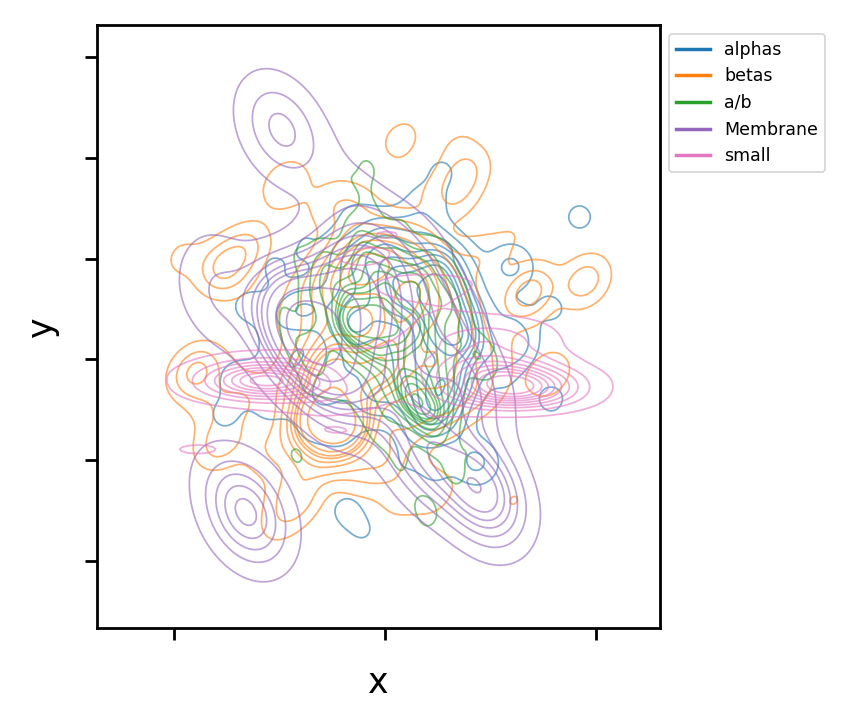

In [27]:
fig = plt.figure(figsize=(3.5, 3), dpi=250)
ax = fig.add_subplot(111)

label_order = [
    "a",
    "b",
    "c",
    "f",
    "g"
]

colors = {
    "a": sns.color_palette()[0],
    "b": sns.color_palette()[1],
    "c": sns.color_palette()[2],
    "d": sns.color_palette()[8],
    "e": sns.color_palette()[5],
    "f": sns.color_palette()[4],
    "g": sns.color_palette()[6],
}

pretty_names = {
    "a": "alphas",
    "b": "betas",
    "c": "a/b",
    "d": "a+b",
    "e": "Multi domain",
    "f": "Membrane",
    "g": "small",
}

colorpal = [colors[o] for o in label_order]
'''
for i,cl in enumerate(test_set['Class'].unique()):
    mask = test_set['Class'] == cl
    x = ts[mask,0]
    print(x.shape)
    y = ts[mask,1]
    print(y.shape)
    ax.scatter(x=x,y=y,s=1, c=colorpal[i])
'''
for i, cl in enumerate(label_order):
    mask = SCOP_labels == cl
    x = umap_embedding[mask, 0]
    y = umap_embedding[mask, 1]
    data = pd.DataFrame({'x': x, 'y': y})
    # Utilizza KDE separatamente per ciascuna classe
    sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl, 
                colors=[colorpal[i]], cmap=None, linewidths=.5, alpha=.6)

custom_lines = [
    Line2D([0], [0], color=colors[o], lw=1) for o in label_order
]

legend = ax.legend(custom_lines, [pretty_names[o] for o in label_order], loc="upper left", fontsize=5)

legend.set_bbox_to_anchor((1, 1))
legend.get_frame().set_linewidth(0.5)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.show()

In [28]:
tsne = TSNE(n_jobs=16, perplexity=600, random_state=42)
ts = tsne.fit_transform(X)

In [29]:
umap_model = umap.UMAP(n_components=2, n_epochs=100, random_state=42)
umap_embedding = umap_model.fit_transform(X)

c:\Users\paolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3425583169.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3425583169.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3425583169.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3425583169.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting 

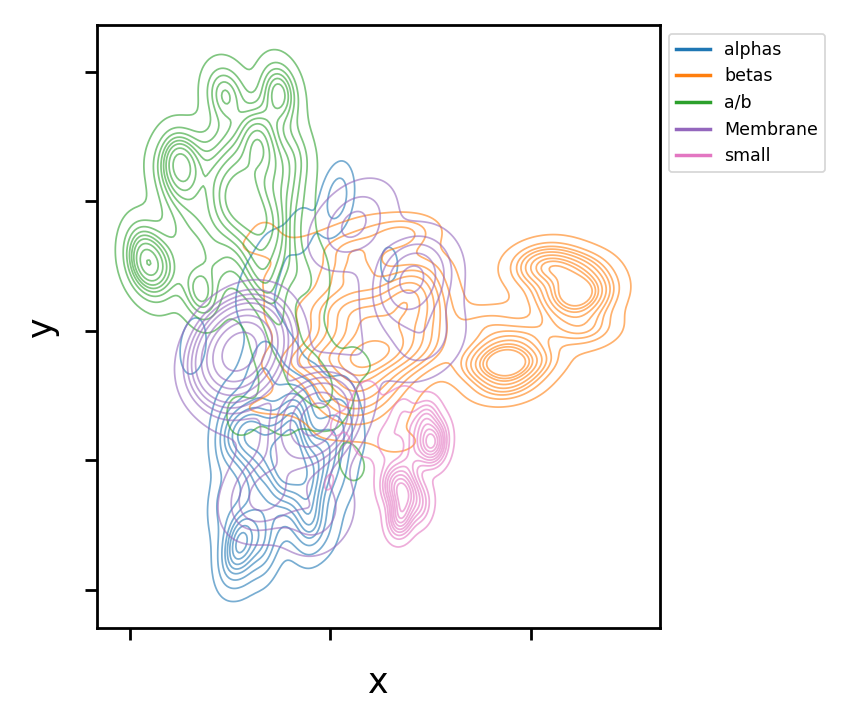

In [30]:
fig = plt.figure(figsize=(3.5, 3), dpi=250)
ax = fig.add_subplot(111)

label_order = [
    "a",
    "b",
    "c",
    "f",
    "g"
]

colors = {
    "a": sns.color_palette()[0],
    "b": sns.color_palette()[1],
    "c": sns.color_palette()[2],
    "d": sns.color_palette()[8],
    "e": sns.color_palette()[5],
    "f": sns.color_palette()[4],
    "g": sns.color_palette()[6],
}

pretty_names = {
    "a": "alphas",
    "b": "betas",
    "c": "a/b",
    "d": "a+b",
    "e": "Multi domain",
    "f": "Membrane",
    "g": "small",
}

colorpal = [colors[o] for o in label_order]
'''
for i,cl in enumerate(test_set['Class'].unique()):
    mask = test_set['Class'] == cl
    x = ts[mask,0]
    print(x.shape)
    y = ts[mask,1]
    print(y.shape)
    ax.scatter(x=x,y=y,s=1, c=colorpal[i])
'''
for i, cl in enumerate(label_order):
    mask = SCOP_labels == cl
    x = ts[mask, 0]
    y = ts[mask, 1]
    data = pd.DataFrame({'x': x, 'y': y})
    # Utilizza KDE separatamente per ciascuna classe
    sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl, 
                colors=[colorpal[i]], cmap=None, linewidths=.5, alpha=.6)

custom_lines = [
    Line2D([0], [0], color=colors[o], lw=1) for o in label_order
]

legend = ax.legend(custom_lines, [pretty_names[o] for o in label_order], loc="upper left", fontsize=5)

legend.set_bbox_to_anchor((1, 1))
legend.get_frame().set_linewidth(0.5)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.show()

C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3927261163.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3927261163.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3927261163.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl,
C:\Users\paolo\AppData\Local\Temp\ipykernel_13424\3927261163.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting 

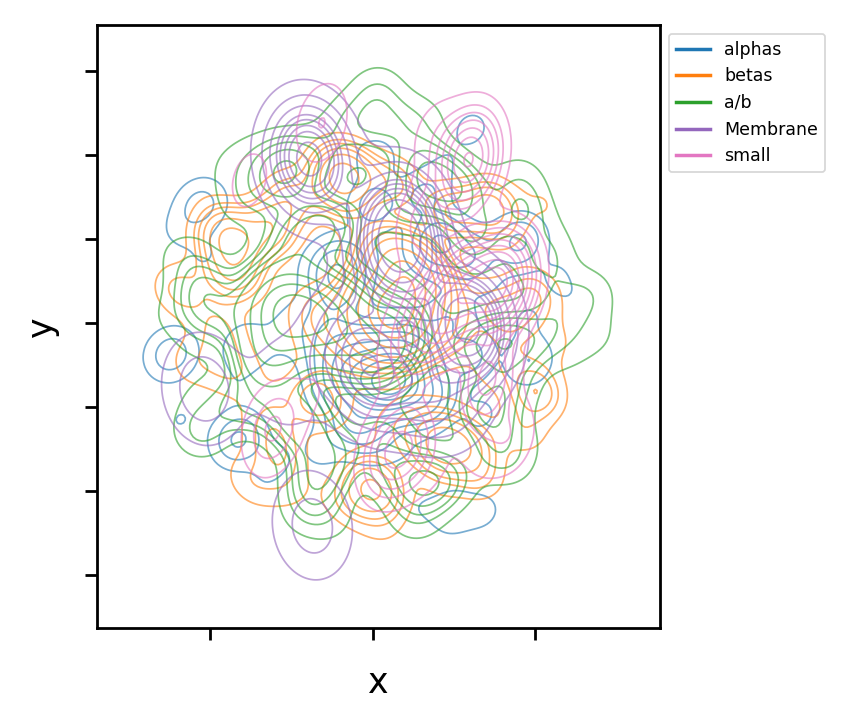

In [31]:
fig = plt.figure(figsize=(3.5, 3), dpi=250)
ax = fig.add_subplot(111)

label_order = [
    "a",
    "b",
    "c",
    "f",
    "g"
]

colors = {
    "a": sns.color_palette()[0],
    "b": sns.color_palette()[1],
    "c": sns.color_palette()[2],
    "d": sns.color_palette()[8],
    "e": sns.color_palette()[5],
    "f": sns.color_palette()[4],
    "g": sns.color_palette()[6],
}

pretty_names = {
    "a": "alphas",
    "b": "betas",
    "c": "a/b",
    "d": "a+b",
    "e": "Multi domain",
    "f": "Membrane",
    "g": "small",
}

colorpal = [colors[o] for o in label_order]
'''
for i,cl in enumerate(test_set['Class'].unique()):
    mask = test_set['Class'] == cl
    x = ts[mask,0]
    print(x.shape)
    y = ts[mask,1]
    print(y.shape)
    ax.scatter(x=x,y=y,s=1, c=colorpal[i])
'''
for i, cl in enumerate(label_order):
    mask = SCOP_labels == cl
    x = umap_embedding[mask, 0]
    y = umap_embedding[mask, 1]
    data = pd.DataFrame({'x': x, 'y': y})
    # Utilizza KDE separatamente per ciascuna classe
    sns.kdeplot(data=data, x='x', y='y', shade=False, label=cl, 
                colors=[colorpal[i]], cmap=None, linewidths=.5, alpha=.6)

custom_lines = [
    Line2D([0], [0], color=colors[o], lw=1) for o in label_order
]

legend = ax.legend(custom_lines, [pretty_names[o] for o in label_order], loc="upper left", fontsize=5)

legend.set_bbox_to_anchor((1, 1))
legend.get_frame().set_linewidth(0.5)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.show()